In [1]:
import cv2
import gc
import numpy as np
import matplotlib.pyplot as plt
import dicom as pdicom
import os
import pandas as pd
import numpy as np
import random


from PIL import Image
from collections import Counter
from natsort import natsorted

import tensorflow as tf
import keras
import keras.backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img

### postavke za konfiguraciju
config = tf.ConfigProto( device_count = {'GPU': 2 , 'CPU': 2} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

/home/ibrahimhadzic45/anaconda3/envs/tf/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
Using TensorFlow backend.


In [2]:
## list all dicom images
dicom_path = "VarianDataset"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(dicom_path):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

In [3]:
# Gets ROI Numbers of contours for cancers only, ignoring other contours 
def get_cancer_contours_only(ROISequence):
    cancers = []
    for elem in ROISequence:
        if "POI" in elem.ROIName:
            continue
        elif "BODY" in elem.ROIName:
            continue
        cancers.append([elem.ROIName, int(elem.ROINumber)])
    return cancers

In [4]:
# 
def uid_slicing_range(RS_elem):
    return_list = []
    beginning = 0
    cancers   = get_cancer_contours_only(RS_elem.StructureSetROISequence)
    
    for elem in RS_elem.ROIContourSequence:
        end = len(elem.ContourSequence) - 1
        
        for cancer in cancers:
            if int(elem.ReferencedROINumber) == cancer[1]:
                range_start = int(elem.ContourSequence[beginning].ContourData[2])
                range_end   = int(elem.ContourSequence[end].ContourData[2])
                
                if range_start != range_end:
                    ref_UID = RS_elem.ReferencedFrameOfReferenceSequence[0].FrameOfReferenceUID
                    
                    return_list.append([ref_UID, range_start, range_end])
    
    return return_list

In [5]:
RS = []
for elem in lstFilesDCM:
    if "RS" not in elem:
        continue
    elif "MR" in elem:
        continue
    RS.append(pdicom.read_file(elem))

In [6]:
slicing_list = []
for RS_elem in RS:
    try:
        slicing_elem = uid_slicing_range(RS_elem)
        if slicing_elem:
            slicing_list.append(slicing_elem)
    except AttributeError:
        pass

In [7]:
arr = []
d = dict()

# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    if "Image" not in filenameDCM:
        continue
    elif "CT" not in filenameDCM:
        continue
    
    # read the file
    ds = pdicom.read_file(filenameDCM)
    arr.append(ds.pixel_array.shape)
    shape = ds.pixel_array.shape
    
    if shape in d.keys():
        d[shape].append(filenameDCM)
    else:
        d[shape] = [filenameDCM]

print(len(arr))
Counter(arr)

2860


Counter({(512, 512): 2860})

In [8]:
# sorting the images the way they were scanned
for key, value in d.items():
    d[key] = natsorted(value)

In [9]:
# Resizing with maintaining aspect ratio and adding padding if necessary

def resize_pad_image(path):
    im = pdicom.read_file(path).pixel_array
    im = array_to_img(im.reshape(len(im), len(im[0]), -1))
    
    IMG_SIZE = 224      

    new_size   = tuple([int(x*(float(IMG_SIZE)/max(im.size))) for x in im.size])
    im_resized = im.resize(new_size, Image.ANTIALIAS)
    new_im     = Image.new("L", (IMG_SIZE, IMG_SIZE))
    new_im.paste(im_resized, 
                 ((IMG_SIZE-new_size[0])//2,
                  (IMG_SIZE-new_size[1])//2))

    return np.array(new_im).reshape(224, 224, 1)

In [10]:
data = []
for key, value in d.items():
    for img_path in natsorted(value):
        metadata = pdicom.read_file(img_path)
        
        data.append([metadata, img_path, resize_pad_image(img_path)])

In [11]:
def data_labelling(data, slicing_list):
    return_data = []
    for image_data in data:
        img_metadata = image_data[0]
        img_array    = image_data[2]
        
        for slicing_elems in slicing_list:
            for elem in slicing_elems:
                #print(img_metadata)
                if elem[0] == img_metadata.FrameOfReferenceUID:
                    range_start  = elem[1]
                    range_end    = elem[2]
                    # SliceLocation missing in some data, we have found out that 
                    # we can use ImagePositionPatient's last element since they're the same value
                    img_location = int(img_metadata.ImagePositionPatient[-1]) 

                    if img_location >= range_start and img_location <= range_end:
                        # oznacit sliku kao kancer
                        return_data.append([img_array, 1])
                    else:
                        # oznacit kao ne
                        return_data.append([img_array, 0])
    return return_data

In [12]:
data_for_neural_net = data_labelling(data, slicing_list)

In [13]:
random.shuffle(data_for_neural_net)

In [14]:
X = []
y = []
for image, label in data_for_neural_net:
    #X.append(image)
    X.append(np.stack((image.reshape(224,224),)*3, -1)) # making an RGB out of grayscale
    y.append(label)

In [15]:
y = keras.utils.to_categorical(y)
y.shape

(4327, 2)

In [16]:
#X = np.array(X).reshape(-1, 224, 224, 1)
X = np.array(X).reshape(-1, 224, 224, 3)
X = np.multiply(X, 1.0/255.0)
X.shape

(4327, 224, 224, 3)

In [17]:
#y = np.array(y).reshape(-1, 1)
#y.shape

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

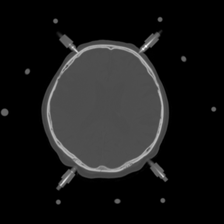

In [19]:
array_to_img(X_train[20])

In [32]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense
model = VGG16(weights='imagenet', include_top=True)

# Generate a model with all layers (with top)

#Add a layer where input is the output of the  second last layer 
model.layers.pop()
model.layers.pop()
model.layers.pop()
x = Dense(2048, activation='relu', name='fc1')(model.layers[-1].output)
x = Dense(2048, activation='relu', name='fc2')(x)
x = Dense(2, activation='softmax', name='predictions')(x)

#Then create the corresponding model 
model = Model(input=model.input, output=x)
#for layer in model.layers[:-3]:
#    layer.trainable = False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/home/ibrahimhadzic45/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`


In [33]:
from keras.optimizers import SGD
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
parallel_model = keras.utils.multi_gpu_model(model, gpus=2)
parallel_model.compile( loss = "categorical_crossentropy", 
               optimizer = sgd, 
               metrics=['accuracy'])

In [34]:
# training on all data we have, ignoring train and test sets
parallel_model.fit(X, y, 
                   epochs=120, batch_size=64, validation_split=0.1)


Train on 3894 samples, validate on 433 samples
Epoch 1/120
3894/3894 [==============================] - 29s 7ms/step - loss: 0.2876 - acc: 0.9165 - val_loss: 0.2657 - val_acc: 0.9122
Epoch 2/120
3894/3894 [==============================] - 24s 6ms/step - loss: 0.2490 - acc: 0.9165 - val_loss: 0.2666 - val_acc: 0.9122
Epoch 3/120
3894/3894 [==============================] - 24s 6ms/step - loss: 0.2375 - acc: 0.9173 - val_loss: 0.2385 - val_acc: 0.9145
Epoch 4/120
3894/3894 [==============================] - 24s 6ms/step - loss: 0.2154 - acc: 0.9219 - val_loss: 0.2179 - val_acc: 0.9145
Epoch 5/120
3894/3894 [==============================] - 24s 6ms/step - loss: 0.2034 - acc: 0.9237 - val_loss: 0.1885 - val_acc: 0.9169
Epoch 6/120
3894/3894 [==============================] - 24s 6ms/step - loss: 0.1865 - acc: 0.9299 - val_loss: 0.1805 - val_acc: 0.9261
Epoch 7/120
3894/3894 [==============================] - 24s 6ms/step - loss: 0.1794 - acc: 0.9281 - val_loss: 0.1900 - val_acc: 0.9169
E

3894/3894 [==============================] - 24s 6ms/step - loss: 0.0931 - acc: 0.9453 - val_loss: 0.1802 - val_acc: 0.9122
Epoch 61/120
3894/3894 [==============================] - 24s 6ms/step - loss: 0.0913 - acc: 0.9476 - val_loss: 0.1786 - val_acc: 0.9145
Epoch 62/120
3894/3894 [==============================] - 24s 6ms/step - loss: 0.0911 - acc: 0.9479 - val_loss: 0.1834 - val_acc: 0.9007
Epoch 63/120
3894/3894 [==============================] - 24s 6ms/step - loss: 0.0933 - acc: 0.9492 - val_loss: 0.1919 - val_acc: 0.9030
Epoch 64/120
3894/3894 [==============================] - 24s 6ms/step - loss: 0.0917 - acc: 0.9479 - val_loss: 0.1632 - val_acc: 0.9192
Epoch 65/120
3894/3894 [==============================] - 24s 6ms/step - loss: 0.0911 - acc: 0.9479 - val_loss: 0.1657 - val_acc: 0.9053
Epoch 66/120
3894/3894 [==============================] - 24s 6ms/step - loss: 0.0925 - acc: 0.9486 - val_loss: 0.1620 - val_acc: 0.9145
Epoch 67/120
3894/3894 [==============================

Epoch 120/120
3894/3894 [==============================] - 24s 6ms/step - loss: 0.0827 - acc: 0.9494 - val_loss: 0.1879 - val_acc: 0.9076


In [ ]:
#score = parallel_model.evaluate(X_test, y_test)

In [ ]:
#for i in range(0, len(score)):
#    print(parallel_model.metrics_names[i] + " : " + str(score[i]) + "\n")

In [31]:
#del model
#del parallel_model

In [39]:
parallel_model.save('varian_CT_cnn.h5')